# Validation
- Evaluate the models
    - Performance metrics
        - WandB Logging - Metrics, Artifacts (Table, Model.pkl, plots)
        - Multi-Classification Metrics Logging
        - SHAP for the encoded class to investigate the customer purchase behavior
    - AI ethics
        - FairLearn

In [1]:
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import joblib

import math

# Data

In [2]:
# Features, Target
X_train = pd.read_parquet("data/L2/X_train.parquet")
y_train = pd.read_parquet("data/L2/y_train.parquet")
X_val = pd.read_parquet("data/L2/X_val.parquet")
y_val = pd.read_parquet("data/L2/y_val.parquet")
X_score = pd.read_parquet("data/L2/X_score.parquet")

In [3]:
# Model
gbm = joblib.load("model/lgb_multiclass.pkl")

In [4]:
# Synthetic Data for Checking
synthetic_under_insured_data = pd.read_parquet("data/L1/synthetic_under_insured_customer.parquet")
synthetic_high_income_data = pd.read_parquet("data/L1/synthetic_high_income_customer.parquet")
synthetic_dependents_needs_data = pd.read_parquet("data/L1/synthetic_depends_customer.parquet")

# Evaluate
- Metrics

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import json
import os
import shap
import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary
import joblib

parmas = {"objective": "evaluate", "num_class": 6, "metric": "multi_logloss"}

wandb_run = wandb.init(project="ai-coding-project", config=parmas)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: howt51. Use `wandb login --relogin` to force relogin


## Multi-Model Metrics

In [6]:
def calculate_multiclass_metrics(y_actual, y_pred_prob, display=True):
    # Convert probabilities to predicted class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_actual, y_pred)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(y_actual, y_pred, average=None)
    recall = recall_score(y_actual, y_pred, average=None)
    f1 = f1_score(y_actual, y_pred, average=None)

    # Calculate macro, micro and weighted averages of precision, recall and F1 score
    precision_macro = precision_score(y_actual, y_pred, average="macro")
    recall_macro = recall_score(y_actual, y_pred, average="macro")
    f1_macro = f1_score(y_actual, y_pred, average="macro")

    precision_micro = precision_score(y_actual, y_pred, average="micro")
    recall_micro = recall_score(y_actual, y_pred, average="micro")
    f1_micro = f1_score(y_actual, y_pred, average="micro")

    precision_weighted = precision_score(y_actual, y_pred, average="weighted")
    recall_weighted = recall_score(y_actual, y_pred, average="weighted")
    f1_weighted = f1_score(y_actual, y_pred, average="weighted")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Generate classification report
    class_report = classification_report(y_actual, y_pred, output_dict=True)

    # Print the metrics
    if display:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (per class): {precision}")
        print(f"Recall (per class): {recall}")
        print(f"F1 Score (per class): {f1}")

        print(f"Macro-Average Precision: {precision_macro:.4f}")
        print(f"Macro-Average Recall: {recall_macro:.4f}")
        print(f"Macro-Average F1 Score: {f1_macro:.4f}")

        print(f"Micro-Average Precision: {precision_micro:.4f}")
        print(f"Micro-Average Recall: {recall_micro:.4f}")
        print(f"Micro-Average F1 Score: {f1_micro:.4f}")

        print(f"Weighted-Average Precision: {precision_weighted:.4f}")
        print(f"Weighted-Average Recall: {recall_weighted:.4f}")
        print(f"Weighted-Average F1 Score: {f1_weighted:.4f}")

        print("Confusion Matrix:")
        print(conf_matrix)

        print("Classification Report:")
        print(classification_report(y_actual, y_pred))

    metrics = {
        f"accuracy": accuracy,
        f"precision": precision,
        f"recall": recall,
        f"f1": f1,
        f"precision_macro": precision_macro,
        f"recall_macro": recall_macro,
        f"f1_macro": f1_macro,
        f"precision_micro": precision_micro,
        f"recall_micro": recall_micro,
        f"f1_micro": f1_micro,
        f"precision_weighted": precision_weighted,
        f"recall_weighted": recall_weighted,
        f"f1_weighted": f1_weighted,
        f"confusion_matrix": conf_matrix,
        f"classification_report": class_report,
    }

    return metrics

In [7]:
def log_wandb_metrics(metrics, wandb_run, prefix="", directory=""):
    # Log metrics to Weights and Biases
    if wandb_run is None:
        wandb_run = wandb.init(project="multiclass-metrics", reinit=True)

    # Log the metrics
    prefixed_metrics = {"prefix_" + k: v for k, v in metrics.items()}
    wandb.log(prefixed_metrics)

    # Save confusion matrix and classification report as JSON files
    with open(f"{directory}/{prefix}_confusion_matrix.json", "w") as f:
        json.dump(metrics["confusion_matrix"].tolist(), f)

    with open(f"{directory}/{prefix}_classification_report.json", "w") as f:
        json.dump(metrics["classification_report"], f)

    # Create wandb artifacts
    artifact = wandb.Artifact("multiclass-metrics-artifacts", type="metrics")
    artifact.add_file(f"{directory}/{prefix}_confusion_matrix.json")
    artifact.add_file(f"{directory}/{prefix}_classification_report.json")

    # Log the artifacts
    wandb_run.log_artifact(artifact)

In [8]:
def log_wandb_shap(model, data, wandb_run, directory=""):
    # Log metrics to Weights and Biases
    if wandb_run is None:
        wandb_run = wandb.init(project="multiclass-metrics", reinit=True)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    # Save SHAP values
    shap_values_filename = f"{directory}/shap_values.npy"
    np.save(shap_values_filename, shap_values.values)

    shap_artifact = wandb.Artifact("shap-artifact", type="shap")
    shap_artifact.add_file(shap_values_filename)
    wandb_run.log_artifact(shap_artifact)

    # Save SHAP summary plot
    shap.summary_plot(shap_values, data, feature_names=data.columns, show=False)
    shap_summary_filename = f"{directory}/shap_summary.png"
    plt.savefig(shap_summary_filename)
    # plt.close()

    wandb_run.log({"SHAP Summary Plot": wandb.Image(shap_summary_filename)})

## Train Metrics

In [9]:
policy_cat_map = {
    "Medical": 0,
    "Critical Illness": 1,
    "Endowment": 2,
    "Investment": 3,
    "Whole Life": 4,
    "Term Life": 5,
}

Accuracy: 0.8446
Precision (per class): [0.84615385 0.79532164 0.89814815 0.94444444 1.         0.81632653]
Recall (per class): [0.82706767 0.91891892 0.8362069  0.73913043 0.86666667 0.74074074]
F1 Score (per class): [0.8365019  0.85266458 0.86607143 0.82926829 0.92857143 0.77669903]
Macro-Average Precision: 0.8834
Macro-Average Recall: 0.8215
Macro-Average F1 Score: 0.8483
Micro-Average Precision: 0.8446
Micro-Average Recall: 0.8446
Micro-Average F1 Score: 0.8446
Weighted-Average Precision: 0.8492
Weighted-Average Recall: 0.8446
Weighted-Average F1 Score: 0.8443
Confusion Matrix:
[[110  13   7   0   0   3]
 [  8 136   0   0   0   4]
 [  6  10  97   1   0   2]
 [  3   2   1  17   0   0]
 [  1   1   0   0  13   0]
 [  2   9   3   0   0  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       133
           1       0.80      0.92      0.85       148
           2       0.90      0.84      0.87       116
        

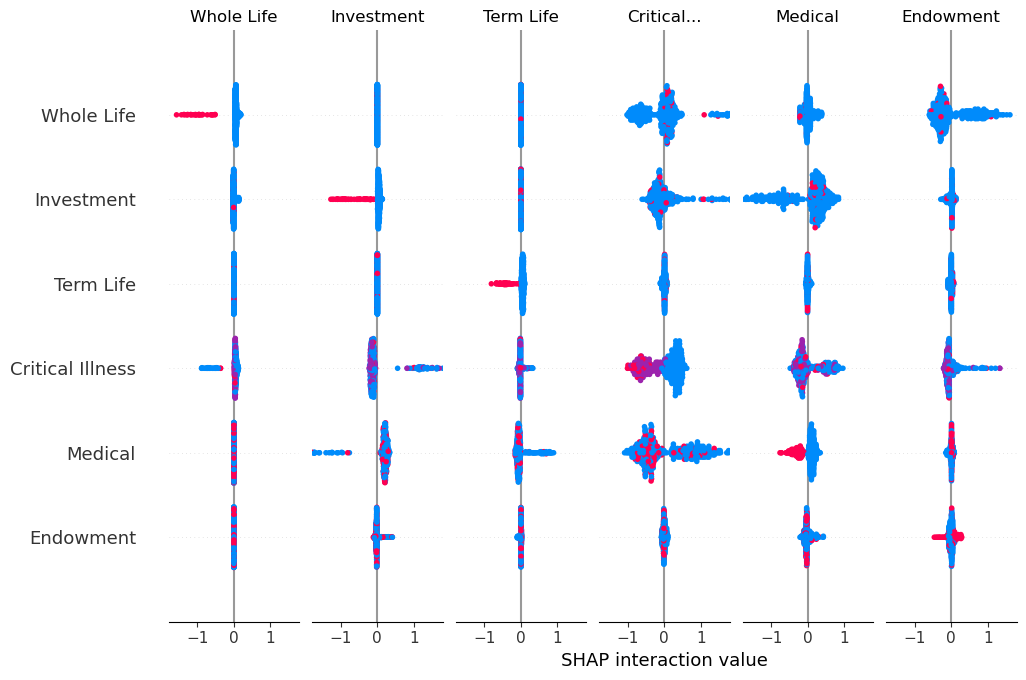

In [10]:
# predict
y_train_predict_prob = gbm.predict(X_train, num_iteration=gbm.best_iteration)
train_metrics = calculate_multiclass_metrics(y_train, y_train_predict_prob)
log_wandb_metrics(train_metrics, wandb_run, prefix="train", directory="tmpt")
log_wandb_shap(gbm, X_train, wandb_run, directory="tmpt")

In [11]:
def log_wandb_individual_shap(model, data, target_class_idx,  wandb_run, directory=""):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    # Save SHAP summary plot
    class_index=target_class_idx
    shap.summary_plot(shap_values[..., class_index], data, max_display=7)
    shap_summary_filename = f"{directory}/shap_summary_{class_index}.png"
    plt.savefig(shap_summary_filename)
    plt.close()

    wandb_run.log({f"SHAP Summary Plot Class {class_index}": wandb.Image(shap_summary_filename)})

## Investigate the customer purchase behavoir

### CI

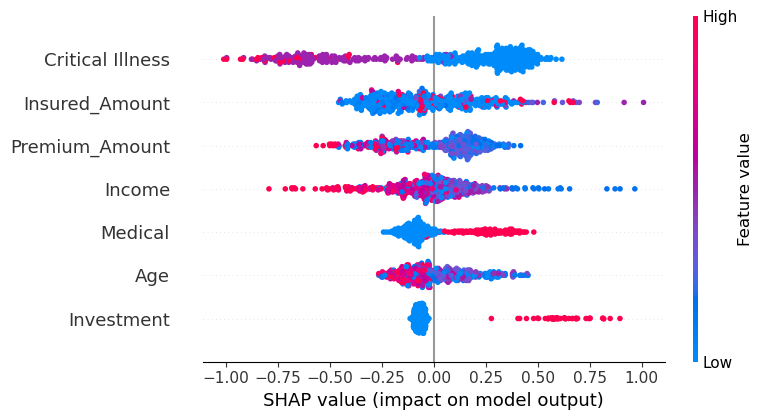

In [12]:
# Behavoir for Customer who is getting CI
log_wandb_individual_shap(gbm, X_train, 1, wandb_run, directory="tmpt")

### Endowment

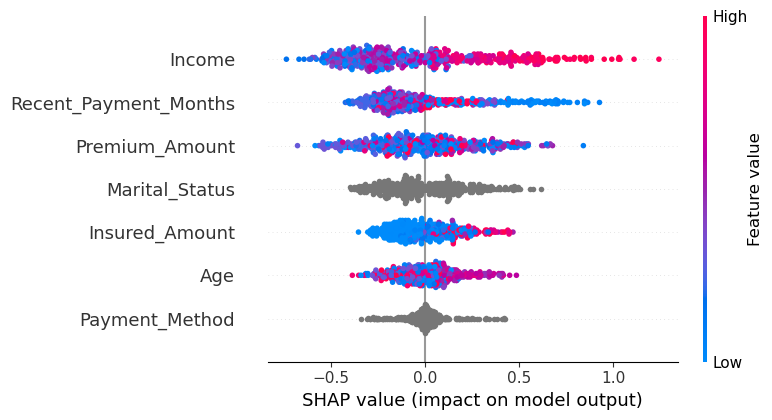

In [13]:
# Behavoir for CUstomer who is getting Endowment
log_wandb_individual_shap(gbm, X_train, 2, wandb_run, directory="tmpt")

### Term Life

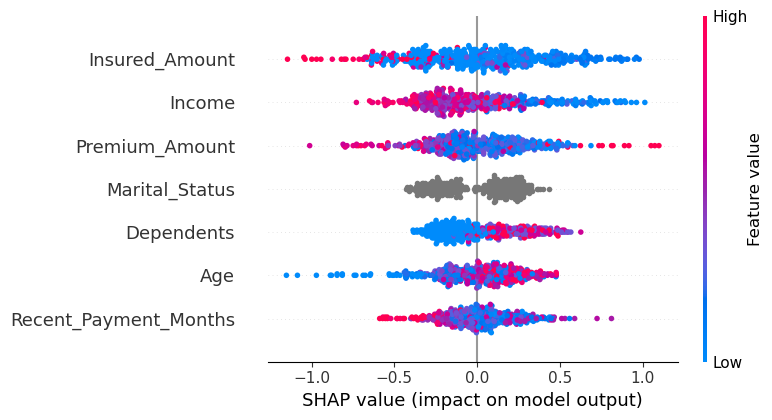

In [14]:
# Behavoir for CUstomer who is getting Term Life
log_wandb_individual_shap(gbm, X_train, 5, wandb_run, directory="tmpt")

## Validation Metrics 

In [15]:
y_val_predict_prob = gbm.predict(X_val, num_iteration=gbm.best_iteration)
val_metrics = calculate_multiclass_metrics(y_val, y_val_predict_prob, wandb_run)
log_wandb_metrics(val_metrics, wandb_run, prefix="val", directory="tmpt")

Accuracy: 0.4415
Precision (per class): [0.48275862 0.5        0.28571429 0.5        1.         0.4       ]
Recall (per class): [0.47457627 0.56451613 0.34285714 0.14285714 0.33333333 0.27272727]
F1 Score (per class): [0.47863248 0.53030303 0.31168831 0.22222222 0.5        0.32432432]
Macro-Average Precision: 0.5281
Macro-Average Recall: 0.3551
Macro-Average F1 Score: 0.3945
Micro-Average Precision: 0.4415
Micro-Average Recall: 0.4415
Micro-Average F1 Score: 0.4415
Weighted-Average Precision: 0.4510
Weighted-Average Recall: 0.4415
Weighted-Average F1 Score: 0.4373
Confusion Matrix:
[[28 16 12  1  0  2]
 [14 35 10  0  0  3]
 [ 8 12 12  0  0  3]
 [ 2  0  4  1  0  0]
 [ 1  0  0  0  1  1]
 [ 5  7  4  0  0  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.47      0.48        59
           1       0.50      0.56      0.53        62
           2       0.29      0.34      0.31        35
           3       0.50      0.14      0.22 

### Confusion Matrix

<Axes: >

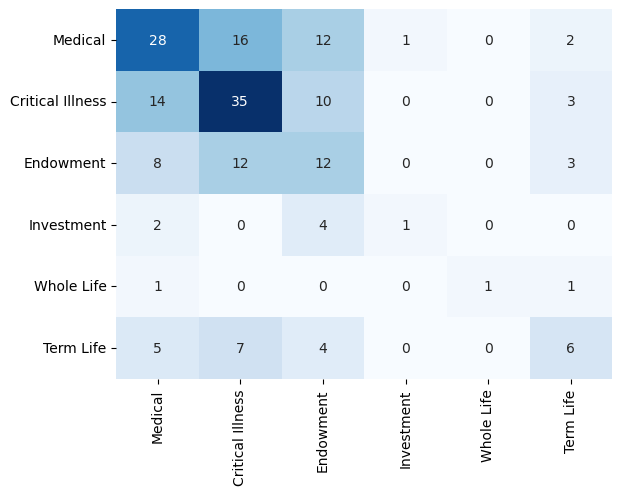

In [16]:
sns.heatmap(
    val_metrics["confusion_matrix"],
    annot=True,
    cmap="Blues",
    cbar=False,
    xticklabels=policy_cat_map.keys(),
    yticklabels=policy_cat_map.keys(),
)

The model demonstrates satisfactory performance for prominent policy categories, such as medical and critical illness. However, for less frequently selected policy types, including endowment and term life, the current model may not be adequately capturing underlying trends and patterns. 

### Classification Report

In [17]:
pd.DataFrame(val_metrics["classification_report"])

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.482759,0.500000,0.285714,0.500000,1.000000,0.400000,0.441489,0.528079,0.450972
recall,0.474576,0.564516,0.342857,0.142857,0.333333,0.272727,0.441489,0.355145,0.441489
f1-score,0.478632,0.530303,0.311688,0.222222,0.500000,0.324324,0.441489,0.394528,0.437329
support,59.000000,62.000000,35.000000,7.000000,3.000000,22.000000,0.441489,188.000000,188.000000


# Ethics
- Via Fairlearn package, assessing and logging fariness through metrics

In [18]:
y_pred_prob = gbm.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)

NameError: name 'X' is not defined

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    count,
    selection_rate,
    false_negative_rate,
    false_positive_rate,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score
import functools

recall = functools.partial(recall_score, average="micro")
precision = functools.partial(precision_score, average="micro")
accuracy = functools.partial(accuracy_score)

# Initialize Wandb run
wandb_run = wandb.init(project="ai-ethics-evaluation")

prefix_accuracy,█▁
prefix_f1_macro,█▁
prefix_f1_micro,█▁
prefix_f1_weighted,█▁
prefix_precision_macro,█▁
prefix_precision_micro,█▁
prefix_precision_weighted,█▁
prefix_recall_macro,█▁
prefix_recall_micro,█▁
prefix_recall_weighted,█▁
prefix_accuracy,0.46114


### Marriage

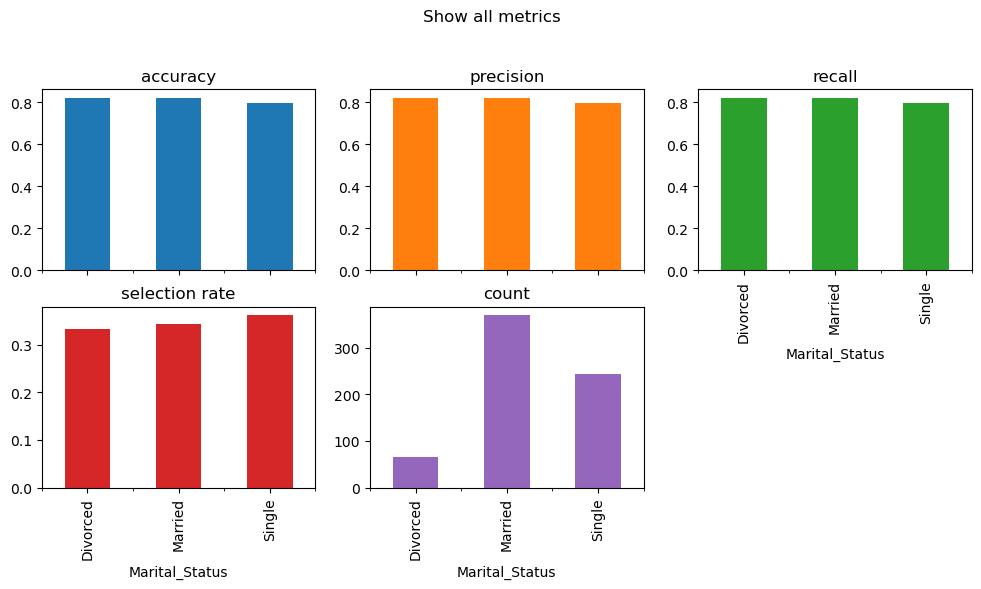

In [ ]:
# Evaluate fairness metrics
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=y,
    y_pred=y_pred,
    sensitive_features=X["Marital_Status"],
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
shap_summary_filename = f"tmpt/fairness_marriage.png"
plt.savefig(shap_summary_filename)

wandb_run.log({"Fairness Marriage Plot": wandb.Image(shap_summary_filename)})

In [ ]:
### Gender

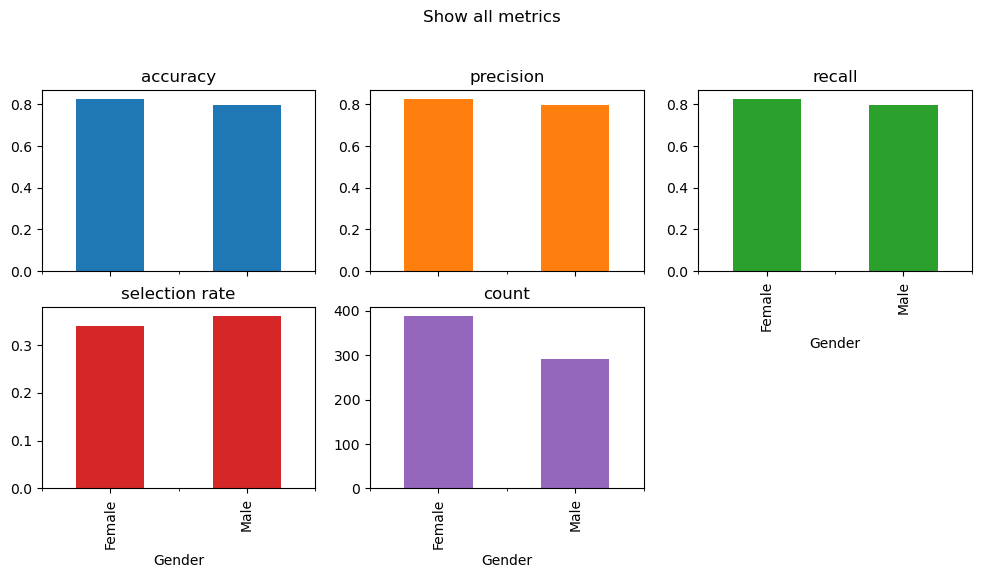

In [ ]:
# Evaluate fairness metrics
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=y,
    y_pred=y_pred,
    sensitive_features=X["Gender"],
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
shap_summary_filename = f"tmpt/fairness_gender.png"
plt.savefig(shap_summary_filename)

wandb_run.log({"Fairness Gender Plot": wandb.Image(shap_summary_filename)})